In [161]:
from scipy.io import readsav
import matplotlib.pyplot as plt 
from matplotlib import dates, colors
import numpy as np 
import pandas as pd 
from sunpy.time import parse_time

## Read in sav files with results

In [162]:
data_file = "stix_spec_fermi.sav"

In [163]:
data = readsav(data_file)["out"]

In [164]:
data.dtype.names

('STIX_DATA',
 'STIX_TIME_EDGES',
 'STIX_TIME_ARR',
 'STIX_ENERGY_EDGES',
 'FIT_PARAMS',
 'FIT_PARAM_SIGMAS',
 'FIT_NAME',
 'FERMI_FIT_TIMES_EDGES',
 'FERMI_FIT_FLUX',
 'FERMI_FIT_FLUX_ERR',
 'FERMI_TIME_ARR',
 'FERMI_EEDGES',
 'C_RATE_PRED',
 'C_RATE_NT_PRED')

In [165]:
stix_data_struct = data["STIX_DATA"][0]
stix_data = stix_data_struct["DATA"][0]
stix_data_err = stix_data_struct["EDATA"][0]
stix_time_arr = data["STIX_TIME_ARR"][0]
stix_tedges = data["STIX_TIME_EDGES"][0]
stix_eedges = data["STIX_ENERGY_EDGES"][0]
fermi_fit_params = data["FIT_PARAMS"][0]
fermi_fit_params_err = data["FIT_PARAM_SIGMAS"][0]
fermi_fit_name = data["FIT_NAME"].astype(str)[0]
fermi_fit_tedges = data["FERMI_FIT_TIMES_EDGES"][0]
fermi_ct_flux = data["FERMI_FIT_FLUX"][0]
fermi_ct_flux_err = data["FERMI_FIT_FLUX_ERR"][0]

fermi_mid_times = data["FERMI_TIME_ARR"][0]
fermi_eedges = data["FERMI_EEDGES"][0]


stix_pred = data["C_RATE_PRED"][0]
stix_nt_pred = data["C_RATE_NT_PRED"][0]

### Plot fit data

In [166]:
fermi_mid_times_dt = parse_time(fermi_mid_times, format="utime").datetime
fermi_mid_ens = np.average(fermi_eedges, axis=1)
fermi_en_inds = np.where(fermi_mid_ens<100)[0]

Text(0.5, 1.0, 'FEERMI counts used for fit')

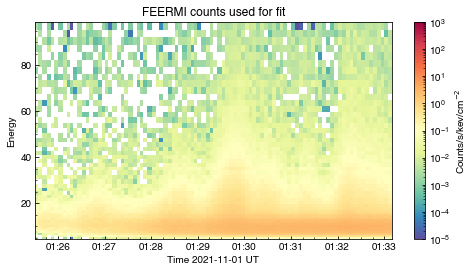

In [167]:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.pcolormesh(fermi_mid_times_dt, 
                    fermi_mid_ens[fermi_en_inds], 
                    fermi_ct_flux[:, fermi_en_inds].T, 
                    norm=colors.LogNorm(vmin=1e-5, vmax=1e3), 
                    cmap="Spectral_r")
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
#ax.set_yscale("log")
#ax.set_ylim(0, 100)
ax.set_ylabel("Energy")
ax.set_xlabel("Time {:s} UT".format(fermi_mid_times_dt[0].strftime("%Y-%m-%d")))
fig.colorbar(im, label="Counts/s/kev/cm$^{-2}$")
ax.set_title("FEERMI counts used for fit")

In [168]:
fermi_inds_615 = np.where((fermi_eedges[:, 0]>=6)&(fermi_eedges[:, 1]<=15))[0]
fermi_inds_1525 = np.where((fermi_eedges[:, 0]>=15)&(fermi_eedges[:, 1]<=25))[0]
fermi_inds_2545 = np.where((fermi_eedges[:, 0]>=25)&(fermi_eedges[:, 1]<=45))[0]

Text(0.5, 0, 'Time')

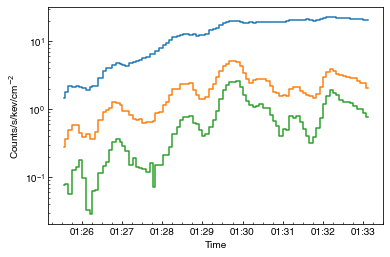

In [169]:
fig, ax = plt.subplots()
plt.plot(fermi_mid_times_dt, 
         np.sum(fermi_ct_flux[:, fermi_inds_615], axis=1), 
         drawstyle="steps-mid")
plt.plot(fermi_mid_times_dt, 
         np.sum(fermi_ct_flux[:, fermi_inds_1525], axis=1), 
         drawstyle="steps-mid")
plt.plot(fermi_mid_times_dt, 
         np.sum(fermi_ct_flux[:, fermi_inds_2545], axis=1), 
         drawstyle="steps-mid")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax.set_ylabel("Counts/s/kev/cm$^{-2}$")
ax.set_xlabel("Time")

Text(0, 0.5, 'Count flux (20-45 keV)')

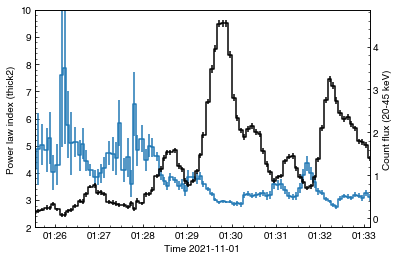

In [170]:
fermi_inds_2045 = np.where((fermi_eedges[:, 0]>=20)&(fermi_eedges[:, 1]<=45))[0]

fig, ax = plt.subplots()
if fermi_fit_name == "vth+thick2":
    ax.errorbar(fermi_mid_times_dt, fermi_fit_params[:, 4], fermi_fit_params_err[:, 4],
                drawstyle="steps-mid")
elif fermi_fit_name == "1pow":
    ax.errorbar(fermi_mid_times_dt, fermi_fit_params[:, 1], fermi_fit_params_err[:, 1],
                drawstyle="steps-mid")
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax.set_xlim(fermi_mid_times_dt[0], fermi_mid_times_dt[-1])
ax.set_ylim(2, 10)

ax2 = ax.twinx()
errors = fermi_ct_flux_err[:, fermi_inds_2045]
err = np.sqrt(np.sum(errors**2, axis=1))
ax2.errorbar(fermi_mid_times_dt, np.sum(fermi_ct_flux[:, fermi_inds_2045], axis=1),
          err,
          drawstyle="steps-mid", color='k')

ax.set_ylabel("Power law index (thick2)")
ax.set_xlabel("Time {:s}".format(fermi_mid_times_dt[0].strftime("%Y-%m-%d")))
ax2.set_ylabel("Count flux (20-45 keV)")

## Plot the resulting data

In [171]:
stix_mid_energies = np.average(stix_eedges, axis=1)
stix_en_inds = np.where(stix_mid_energies<50)[0]

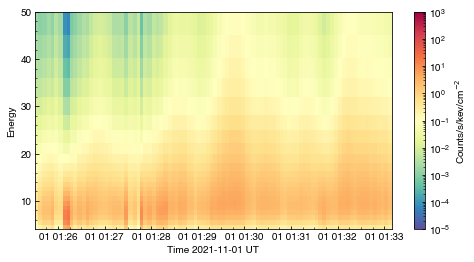

In [172]:
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.pcolormesh(fermi_mid_times_dt, stix_mid_energies[stix_en_inds], 
              stix_pred[:, stix_en_inds].T,
              norm=colors.LogNorm(vmin=1e-5, vmax=1e3), 
              cmap="Spectral_r")

ax.set_ylabel("Energy")
ax.set_xlabel("Time {:s} UT".format(fermi_mid_times_dt[0].strftime("%Y-%m-%d")))
fig.colorbar(im, label="Counts/s/kev/cm$^{-2}$")

## Lets look at the predicted 20-28 keV

In [173]:
t_inds = np.where((stix_tedges[:, 0]>=fermi_fit_tedges[0, 0])&(stix_tedges[:, 1]<=fermi_fit_tedges[-1, 1]))[0]

In [174]:
new_stix = stix_data[t_inds, :]
new_stix_err = stix_data_err[t_inds, :]
new_stix_times = stix_time_arr[t_inds]
new_stix_times_dt = parse_time(new_stix_times, format="utime").datetime
new_stix_tedges = stix_tedges[t_inds, :]

In [175]:
stix_tedges[t_inds, :].shape

(716, 2)

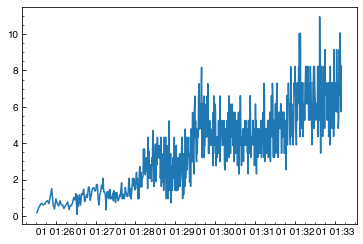

In [176]:
plt.plot(new_stix_times_dt, new_stix[:, 9])

In [177]:
np.sum((stix_data_err[t_inds, :]/len(t_inds))**2, axis=0)

array([1.25393370e-02, 4.17129258e-02, 2.06194183e-01, 7.73666157e-02,
       3.33461565e-02, 1.44226883e-02, 7.46609107e-03, 4.07513748e-03,
       2.33590254e-03, 1.31315744e-03, 8.08501338e-04, 5.34072624e-04,
       1.86047791e-04, 1.26390488e-04, 9.93232228e-05, 5.87601673e-05,
       5.82146015e-05, 3.16214077e-04, 7.34378038e-05, 1.86456564e-05,
       1.07345418e-05, 1.09119346e-05])

First lets resample STIX to the FERMI data bins used for fitting

In [178]:
resampled_stix, resampled_stix_err = [], []
for i in range(len(fermi_fit_tedges)):
    t_inds = np.where((stix_tedges[:, 0]>=fermi_fit_tedges[i, 0])&(stix_tedges[:, 1]<=fermi_fit_tedges[i, 1]))[0]
    av_data = np.mean(stix_data[t_inds, :], axis=0)
    av_err = np.sqrt(np.sum((stix_data_err[t_inds, :]/len(t_inds))**2, axis=0))
    resampled_stix.append(av_data)
    resampled_stix_err.append(av_err)
    
resampled_stix = np.array(resampled_stix)
resampled_stix_err = np.array(resampled_stix_err)

In [179]:
ind_2028 = np.where((stix_eedges[:, 0]>=20)&(stix_eedges[:, 1]<=28))[0]

In [180]:
stix_pred_2028 = np.sum(stix_pred[:, ind_2028], axis=1)
stix_real_2028 = np.sum(resampled_stix[:, ind_2028], axis=1)
stix_real_2028_err = np.sqrt(np.sum(resampled_stix_err[:, ind_2028]**2, axis=1))

(18932.059401296297, 18932.064669537038)

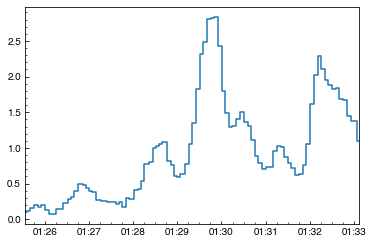

In [181]:
fig, ax = plt.subplots()
ax.plot(fermi_mid_times_dt, stix_pred_2028, 
            drawstyle="steps-mid")
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax.set_xlim(fermi_mid_times_dt[0], fermi_mid_times_dt[-1])

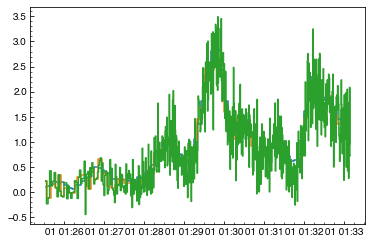

In [182]:
fig, ax = plt.subplots()
ax.plot(fermi_mid_times_dt, stix_pred_2028, 
            drawstyle="steps-mid", label="estimated STIX counts")
ax.plot(fermi_mid_times_dt, stix_real_2028, 
        drawstyle="steps-mid", label="observed STIX counts")
ax.plot(new_stix_times_dt, np.sum(new_stix[:, ind_2028], axis=1), drawstyle="steps-mid")

<ErrorbarContainer object of 3 artists>

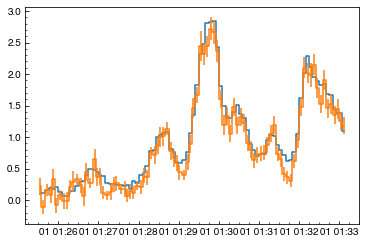

In [183]:
fig, ax = plt.subplots()
ax.plot(fermi_mid_times_dt, stix_pred_2028, 
            drawstyle="steps-mid", label="estimated STIX counts")
ax.errorbar(fermi_mid_times_dt, stix_real_2028, stix_real_2028_err,
        drawstyle="steps-mid", label="observed STIX counts")


Text(0, 0.5, 'Observed STIX counts (20-28 keV)')

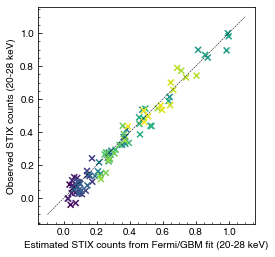

In [184]:
fig, ax = plt.subplots()
ax.scatter(stix_pred_2028/stix_pred_2028.max(), stix_real_2028/stix_real_2028.max(), 
        marker='x', c=fermi_mid_times-fermi_mid_times[0])
ax.set_aspect('equal', adjustable='box')
plt.plot([-0.1, 1.1], [-0.1, 1.1], color='k', ls='dashed', lw=0.5)
ax.set_xlabel("Estimated STIX counts from Fermi/GBM fit (20-28 keV)")
ax.set_ylabel("Observed STIX counts (20-28 keV)")

## Lets now look at directivity

In [185]:
ind_1860 = np.where((stix_eedges[:, 0]>=18)&(stix_eedges[:, 1]<=60))[0]
stix_pred_1860 = np.sum(stix_pred[:, ind_1860], axis=1)
stix_real_1860 = np.sum(resampled_stix[:, ind_1860], axis=1)

In [186]:
i_s, i_e = 50, 55

In [187]:
print(fermi_mid_times_dt[i_s])
print(fermi_mid_times_dt[i_e])

2021-11-01 01:29:42.644500
2021-11-01 01:30:07.733000


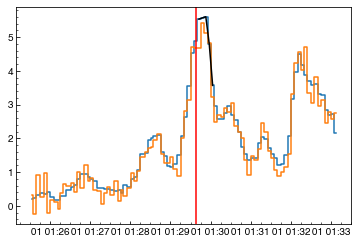

In [329]:
fig, ax = plt.subplots()
ax.plot(fermi_mid_times_dt, stix_pred_1860, drawstyle="steps-mid")
ax.plot(fermi_mid_times_dt, stix_real_1860, drawstyle="steps-mid")
# plt.axvline(fermi_mid_times_dt[i_s])
# plt.axvline(fermi_mid_times_dt[i_e])

ii = 49
plt.axvline(fermi_mid_times_dt[ii], color='r')
plt.plot(fermi_mid_times_dt[i_s:i_e], np.sum(stix_pred[i_s:i_e, ind_1860], axis=1), color='k')

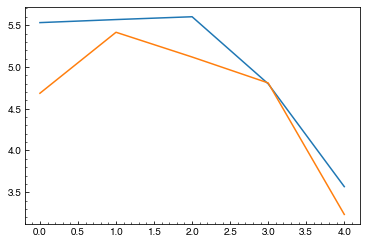

In [330]:
plt.plot(np.sum(stix_pred[i_s:i_e, ind_1860], axis=1))
plt.plot(np.sum(resampled_stix[i_s:i_e, ind_1860], axis=1))

In [331]:
erange = np.where((stix_eedges[:, 0]>=18)&(stix_eedges[:, 1]<=60))[0]
erange.shape

(9,)

In [332]:
f_obs = np.mean(resampled_stix[i_s:i_e, erange], axis=0)
f_pred = np.mean(stix_pred[i_s:i_e, erange], axis=0)

f_obs = resampled_stix[ii, erange]
f_pred = stix_pred[ii, erange]

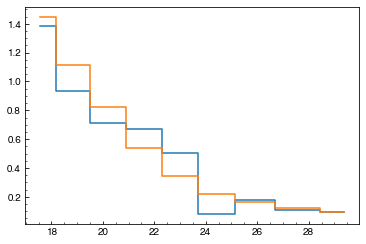

In [333]:
plt.plot(fermi_mid_ens[erange], f_obs, drawstyle="steps-mid")
plt.plot(fermi_mid_ens[erange], f_pred, drawstyle="steps-mid")

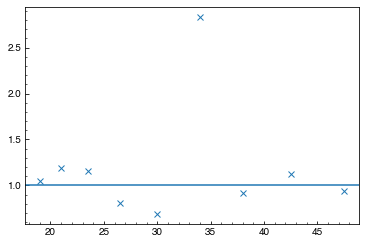

In [335]:
plt.plot(stix_mid_energies[erange], f_pred/f_obs, marker='x', ls='')
plt.axhline(1)
#plt.ylim(0, 2)

## Lets compare predicted data and non-resampled stix data

In [194]:
new_stix_1860 = new_stix[:, ind_1860]

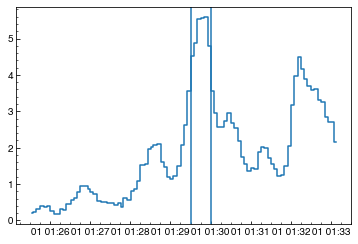

In [195]:
fig, ax = plt.subplots()
ax.plot(fermi_mid_times_dt, stix_pred_1860, drawstyle="steps-mid")
ax.axvline(parse_time("2021-11-01 01:29:30").datetime)
ax.axvline(parse_time("2021-11-01 01:30:00").datetime)

In [252]:
tint_s = parse_time("2021-11-01 01:29:40").utime
tint_e = parse_time("2021-11-01 01:30:00").utime

In [253]:
fermi_fit_tedges.shape

(92, 2)

In [254]:
ints_pred = np.where((fermi_fit_tedges[:, 0]>=tint_s)&(fermi_fit_tedges[:, 1]<=tint_e))[0]
ints_obs = np.where((new_stix_tedges[:, 0]>=tint_s)&(new_stix_tedges[:, 1]<=tint_e))[0]

In [255]:
new_stix_tedges

array([[1.35173313e+09, 1.35173313e+09],
       [1.35173313e+09, 1.35173314e+09],
       [1.35173314e+09, 1.35173314e+09],
       ...,
       [1.35173359e+09, 1.35173359e+09],
       [1.35173359e+09, 1.35173359e+09],
       [1.35173359e+09, 1.35173359e+09]])

In [256]:
stix_obs_test = new_stix_1860[ints_obs, :]
stix_pred_test = stix_pred[:, ind_1860][ints_pred, :]

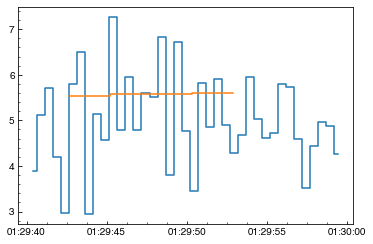

In [257]:
fig, ax = plt.subplots()
ax.plot(new_stix_times_dt[ints_obs], np.sum(stix_obs_test, axis=1), drawstyle="steps-mid")
ax.plot(fermi_mid_times_dt[ints_pred], np.sum(stix_pred_test, axis=1), drawstyle="steps-mid")

In [258]:
f_obs_test = np.mean(stix_obs_test, axis=0)
f_pred_test = np.mean(stix_pred_test, axis=0)

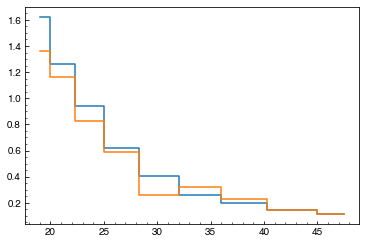

In [259]:
plt.plot(stix_mid_energies[ind_1860], f_pred_test, drawstyle="steps-mid")
plt.plot(stix_mid_energies[ind_1860], f_obs_test, drawstyle="steps-mid")

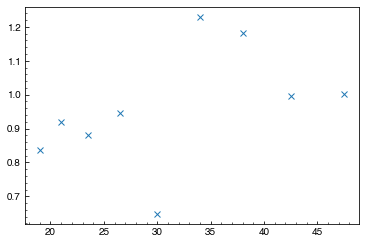

In [260]:
plt.plot(stix_mid_energies[ind_1860], f_obs_test/f_pred_test, marker='x', ls='')